<a href="https://colab.research.google.com/github/X66YSH/DetectYoutubeSpam/blob/main/DetectSpam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


****STA 314 Final Project: DetectSpam****

In [5]:
import pandas as pd


train_data = pd.read_csv('/content/drive/MyDrive/STA314/detect-spam-youtube-comment/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/STA314/detect-spam-youtube-comment/test.csv')

print(train_data.head())



   COMMENT_ID             AUTHOR                     DATE  \
0           1      Brandon Pryor      2014-01-19 00:36:25   
1           2        Chelsea Yun  2015-05-23 07:17:09.691   
2           3  Sofia Aristizabal      2014-09-09 00:43:52   
3           4     said abdesalam  2015-05-24 07:35:13.754   
4           5         crazy girl  2015-05-23 23:26:05.305   

                                             CONTENT  \
0  I dont even watch it anymore i just come here ...   
1                                        i hate rap﻿   
2        I loved, she is amazing.. OMG your eyes*_*﻿   
3                                       song is bad﻿   
4                                       tension⤴︎⤴︎﻿   

                                          VIDEO_NAME  CLASS  
0                     PSY - GANGNAM STYLE(?????) M/V      0  
1          Eminem - Love The Way You Lie ft. Rihanna      0  
2                                  Katy Perry - Roar      0  
3          Eminem - Love The Way You Lie ft. Rih

# EDA: Exploratory Data Analysis



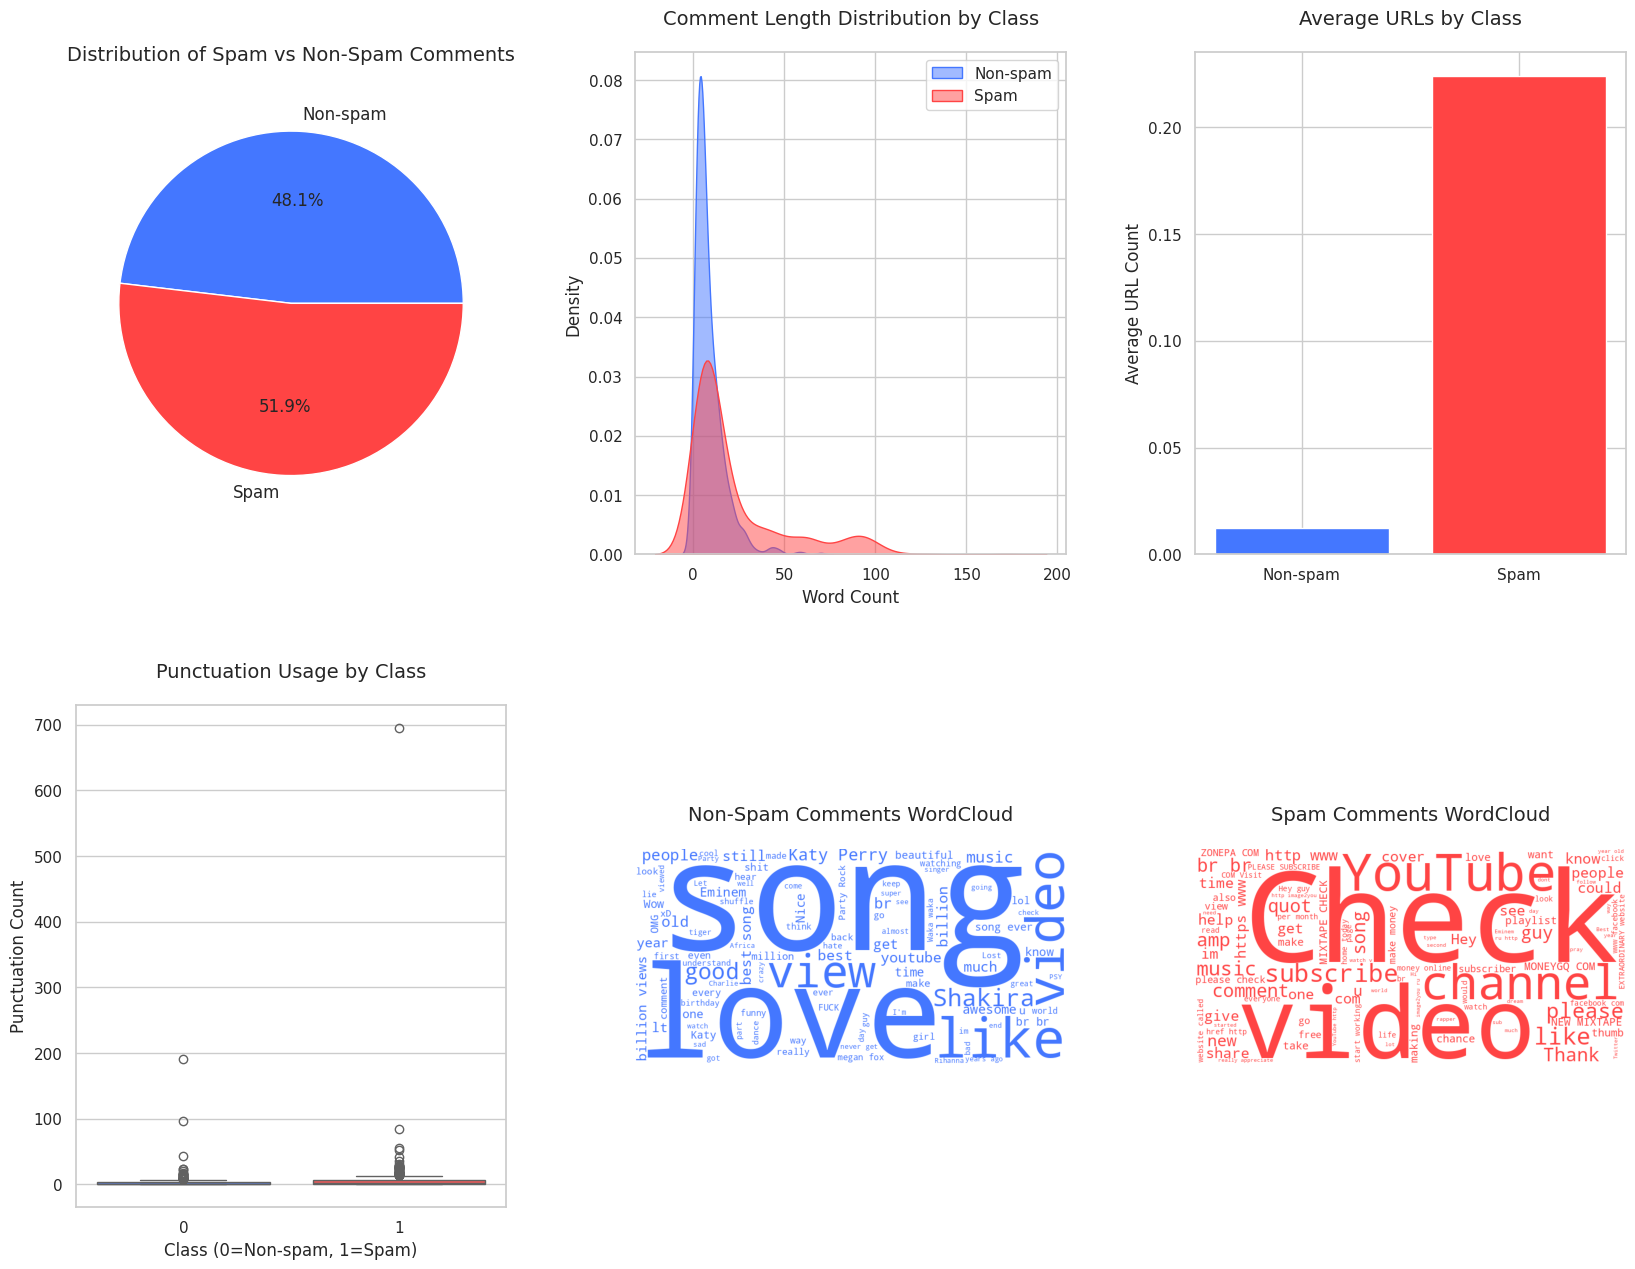

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from collections import Counter
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud
import numpy as np


plt.style.use('default')
sns.set_theme(style="whitegrid")


SPAM_COLOR = '#FF4444'
NON_SPAM_COLOR = '#4477FF'

def create_enhanced_visualizations(train_data):

    fig = plt.figure(figsize=(20, 15))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

    ax1 = fig.add_subplot(gs[0, 0])
    class_counts = train_data['CLASS'].value_counts()
    colors = [NON_SPAM_COLOR, SPAM_COLOR]
    plt.pie(class_counts.sort_index(), labels=['Non-spam', 'Spam'],
            autopct='%1.1f%%', colors=colors,
            textprops={'fontsize': 12})
    plt.title('Distribution of Spam vs Non-Spam Comments', pad=20, fontsize=14)

    ax2 = fig.add_subplot(gs[0, 1])
    for label, color in zip([0, 1], [NON_SPAM_COLOR, SPAM_COLOR]):
        subset = train_data[train_data['CLASS'] == label]['word_count']
        sns.kdeplot(data=subset, ax=ax2, fill=True, color=color,
                   alpha=0.5, label=f'{"Non-spam" if label==0 else "Spam"}')
    ax2.set_title('Comment Length Distribution by Class', pad=20, fontsize=14)
    ax2.set_xlabel('Word Count')
    ax2.set_ylabel('Density')
    ax2.legend()

    ax3 = fig.add_subplot(gs[0, 2])
    url_means = [
        train_data[train_data['CLASS']==0]['url_count'].mean(),
        train_data[train_data['CLASS']==1]['url_count'].mean()
    ]

    ax3.bar(['Non-spam', 'Spam'], url_means, color=[NON_SPAM_COLOR, SPAM_COLOR])
    ax3.set_ylabel('Average URL Count')
    ax3.set_title('Average URLs by Class', pad=20, fontsize=14)

    ax4 = fig.add_subplot(gs[1, 0])
    sns.boxplot(data=train_data, x='CLASS', y='punc_count',
                palette=[NON_SPAM_COLOR, SPAM_COLOR])
    plt.title('Punctuation Usage by Class', pad=20, fontsize=14)
    plt.xlabel('Class (0=Non-spam, 1=Spam)')
    plt.ylabel('Punctuation Count')


    stop_words = set(stopwords.words('english'))


    ax5 = fig.add_subplot(gs[1, 1])
    non_spam_text = " ".join(train_data[train_data['CLASS']==0]['CONTENT'].fillna(""))
    non_spam_wordcloud = WordCloud(
        background_color='white',
        max_words=100,
        stopwords=stop_words,
        width=800,
        height=400,
        color_func=lambda *args, **kwargs: NON_SPAM_COLOR,
        random_state=42
    ).generate(non_spam_text)

    ax5.imshow(non_spam_wordcloud)
    ax5.axis('off')
    ax5.set_title('Non-Spam Comments WordCloud', pad=20, fontsize=14)


    ax6 = fig.add_subplot(gs[1, 2])
    spam_text = " ".join(train_data[train_data['CLASS']==1]['CONTENT'].fillna(""))
    spam_wordcloud = WordCloud(
        background_color='white',
        max_words=100,
        stopwords=stop_words,
        width=800,
        height=400,
        color_func=lambda *args, **kwargs: SPAM_COLOR,
        random_state=42
    ).generate(spam_text)

    ax6.imshow(spam_wordcloud)
    ax6.axis('off')
    ax6.set_title('Spam Comments WordCloud', pad=20, fontsize=14)

    plt.tight_layout()
    plt.show()

def prepare_data(train_data):
    train_data['word_count'] = train_data['CONTENT'].apply(lambda x: len(str(x).split()))
    train_data['url_count'] = train_data['CONTENT'].apply(lambda x: len(re.findall(r'http[s]?://\S+', str(x))))
    train_data['punc_count'] = train_data['CONTENT'].apply(lambda x: sum([1 for ch in str(x) if ch in '.,!?;:']))
    return train_data

def run_enhanced_eda(train_data):
    prepared_data = prepare_data(train_data)
    create_enhanced_visualizations(prepared_data)


run_enhanced_eda(train_data)

# Step 1: Importing Dependencies & Initial Setup

In this cell, we import all necessary packages such as Transformers, Scikit-learn components, XGBoost, LightGBM, and PyTorch. We also configure warnings to be ignored to maintain a clean output.



In [6]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel, DebertaTokenizer, DebertaModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
import torch
import re
import string
from tqdm import tqdm
import nltk
import warnings

warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Step 2: Defining the OptimizedClassifier Class

This step sets up our main classification pipeline. The `OptimizedClassifier` class integrates:
- Pretrained models (DeBERTa, RoBERTa) for feature extraction.
- TF-IDF for additional text features.
- A collection of classifiers for model ensembling.
It also provides methods for training the model on given data and predicting labels for new data.



In [7]:
class OptimizedClassifier:
    def __init__(self):
        # Previous initialization code remains the same
        self.models = {
            'deberta': ('microsoft/deberta-v3-large', None, None),
            'roberta': ('roberta-large', None, None)
        }
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Initialize models
        for name, (model_name, _, _) in self.models.items():
            try:
                if name == 'deberta':
                    tokenizer = DebertaTokenizer.from_pretrained(model_name)
                    model = DebertaModel.from_pretrained(model_name)
                else:
                    tokenizer = AutoTokenizer.from_pretrained(model_name)
                    model = AutoModel.from_pretrained(model_name)
                model.to(self.device)
                model.eval()
                self.models[name] = (model_name, tokenizer, model)
            except Exception as e:
                print(f"Failed to load {name}, skipping... Error: {str(e)}")

        # TF-IDF extractors
        self.tfidf_extractors = {
            'word': TfidfVectorizer(
                max_features=5000,
                ngram_range=(1, 4),
                min_df=2,
                max_df=0.9,
                use_idf=True,
                smooth_idf=True,
                sublinear_tf=True
            ),
            'char': TfidfVectorizer(
                analyzer='char',
                max_features=5000,
                ngram_range=(2, 6),
                min_df=2,
                max_df=0.9,
                use_idf=True,
                smooth_idf=True,
                sublinear_tf=True
            )
        }

        # Classifiers
        self.classifiers = {
            'lr1': LogisticRegression(C=1.5, max_iter=3000),
            'rf': RandomForestClassifier(
                n_estimators=300,
                max_depth=20,
                min_samples_split=4,
                min_samples_leaf=2,
                class_weight='balanced',
                bootstrap=True
            ),
            'xgb': xgb.XGBClassifier(
                n_estimators=300,
                max_depth=8,
                learning_rate=0.05,
                subsample=0.8,
                colsample_bytree=0.8,
                use_label_encoder=False,
                eval_metric='logloss'
            ),
            'lgb': lgb.LGBMClassifier(
                n_estimators=300,
                learning_rate=0.05,
                num_leaves=31,
                subsample=0.8,
                colsample_bytree=0.8,
                class_weight='balanced'
            )
        }
        self.trained_classifiers = {}
        self.is_fitted = False

        try:
            nltk.download('wordnet')
            nltk.download('averaged_perceptron_tagger')
        except Exception as e:
            print(f"Failed to download NLTK data: {str(e)}")

    def clean_text(self, text):
        """Enhanced text cleaning."""
        if not isinstance(text, str):
            return ""

        text = text.lower().strip()
        text = re.sub(r'http[s]?://\S+', '[URL]', text)
        text = re.sub(r'\S+@\S+', '[EMAIL]', text)
        text = re.sub(r'\d+', '[NUM]', text)
        text = re.sub(r'[^a-zA-Z\s\.\!\?]', ' ', text)
        text = re.sub(r'(.)\1{2,}', r'\1\1', text)
        return ' '.join(text.split())

    def get_transformer_features(self, texts, model_tuple, batch_size=4):
        """Extract features from transformer models."""
        _, tokenizer, model = model_tuple
        features = []
        processed_texts = [str(t) for t in texts]

        try:
            for i in range(0, len(processed_texts), batch_size):
                batch_texts = processed_texts[i:i + batch_size]
                encoded = tokenizer(
                    batch_texts,
                    padding=True,
                    truncation=True,
                    max_length=256,
                    return_tensors='pt'
                )
                with torch.no_grad():
                    outputs = model(
                        encoded['input_ids'].to(self.device),
                        encoded['attention_mask'].to(self.device)
                    )
                    features.append(outputs.last_hidden_state.mean(dim=1).cpu().numpy())
            return np.vstack(features)
        except Exception as e:
            print(f"Error in transformer feature extraction: {str(e)}")
            if model is not None and hasattr(model, 'config'):
                return np.zeros((len(processed_texts), model.config.hidden_size))
            else:
                return np.zeros((len(processed_texts), 768))

    def extract_features(self, texts, is_training=False):
        """Extract all features from texts."""
        cleaned_texts = [self.clean_text(text) for text in texts]
        features_list = []

        # Transformer features
        for name, model_tuple in self.models.items():
            if model_tuple[1] is not None:
                print(f"Extracting {name} features...")
                features = self.get_transformer_features(cleaned_texts, model_tuple)
                features_list.append(features)

        # TF-IDF features
        for name, extractor in self.tfidf_extractors.items():
            print(f"Extracting {name} TF-IDF features...")
            if is_training:
                features = extractor.fit_transform(cleaned_texts).toarray()
            else:
                features = extractor.transform(cleaned_texts).toarray()
            features_list.append(features)

        return np.hstack(features_list)

    def fit(self, texts, labels):
        """Train the model on the training set."""
        print("Extracting features for training...")
        combined_features = self.extract_features(texts, is_training=True)

        # Train classifiers
        print("Training classifiers...")
        for name, clf in self.classifiers.items():
            print(f"Training {name}...")
            clf.fit(combined_features, labels)
            self.trained_classifiers[name] = clf

        self.is_fitted = True

    def predict(self, texts):
        """Predict classes for new data."""
        if not self.is_fitted:
            raise ValueError("Model must be fitted before making predictions")

        print("Extracting features for prediction...")
        combined_features = self.extract_features(texts, is_training=False)

        predictions = [clf.predict_proba(combined_features) for clf in self.trained_classifiers.values()]
        final_predictions = np.mean(predictions, axis=0)
        return np.argmax(final_predictions, axis=1)

    def evaluate(self, X_val, y_val):
        """Evaluate model performance on validation set."""
        if not self.is_fitted:
            raise ValueError("Model must be fitted before evaluation")

        from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

        # Get predictions
        val_predictions = self.predict(X_val)

        # Calculate metrics
        metrics = {
            'Precision': precision_score(y_val, val_predictions, average='weighted'),
            'Recall': recall_score(y_val, val_predictions, average='weighted'),
            'F1 Score': f1_score(y_val, val_predictions, average='weighted'),
            'ROC-AUC': roc_auc_score(y_val, val_predictions, multi_class='ovr') if len(np.unique(y_val)) > 2 else roc_auc_score(y_val, val_predictions)
        }

        return metrics

# Step 3: Loading Data and Training the Model

In this step, we load the training and test datasets. We then instantiate our `OptimizedClassifier` and train it using the `fit()` method on the training data.


In [ ]:
print("Loading data...")
train_data = pd.read_csv('/content/drive/MyDrive/STA314/detect-spam-youtube-comment/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/STA314/detect-spam-youtube-comment/test.csv')

print("Initializing classifier...")
classifier = OptimizedClassifier()

print("Training the model...")
classifier.fit(train_data['CONTENT'].values, train_data['CLASS'].values)


Loading data...
Initializing classifier...


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DebertaV2Tokenizer'. 
The class this function is called from is 'DebertaTokenizer'.


Failed to load deberta, skipping... Error: expected str, bytes or os.PathLike object, not NoneType


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Training the model...
Extracting features for training...
Extracting roberta features...


# Step 4: Making Predictions on the Test Set and Saving Results

Now that the model is trained, we predict on the test data and output the results to a `Finalsubmission.csv` file. This file can be used for evaluation or submission purposes.


In [ ]:
print("Predicting on the test set...")
predictions = classifier.predict(test_data['CONTENT'].values)
submission = pd.DataFrame({
    'COMMENT_ID': test_data['COMMENT_ID'],
    'CLASS': predictions
})
submission.to_csv('Finalsubmission.csv', index=False)
print("Done! Results saved to 'Finalsubmission.csv'.")

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    train_data['CONTENT'].values,
    train_data['CLASS'].values,
    test_size=0.2,
    random_state=42,
    stratify=train_data['CLASS'].values
)

# Initialize and train the classifier
classifier = OptimizedClassifier()
classifier.fit(X_train, y_train)

# Evaluate on validation set
metrics = classifier.evaluate(X_val, y_val)

# Print metrics
print("\nModel Performance Metrics on Validation Set:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DebertaV2Tokenizer'. 
The class this function is called from is 'DebertaTokenizer'.


Failed to load deberta, skipping... Error: expected str, bytes or os.PathLike object, not NoneType


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Extracting features for training...
Extracting roberta features...
Extracting word TF-IDF features...
Extracting char TF-IDF features...
Training classifiers...
Training lr1...
Training rf...
Training xgb...
Training lgb...
[LightGBM] [Info] Number of positive: 568, number of negative: 527
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 323748
[LightGBM] [Info] Number of data points in the train set: 1095, number of used features: 3955
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

Extracting features for prediction...
Extracting roberta features...
Extracting word TF-IDF features...
Extracting char TF-IDF features...
Extracting roberta features...
Extracting word TF-IDF features...
Extracting char TF-IDF features...
Extracting roberta features...
Extracting word TF-IDF features...
Extracting char TF-IDF features...
Extracting roberta features...
Extracting word TF-IDF features...
Extracting char TF-IDF features...
Extracting roberta features...
Extracting word TF-IDF features...
Extracting char TF-IDF features...


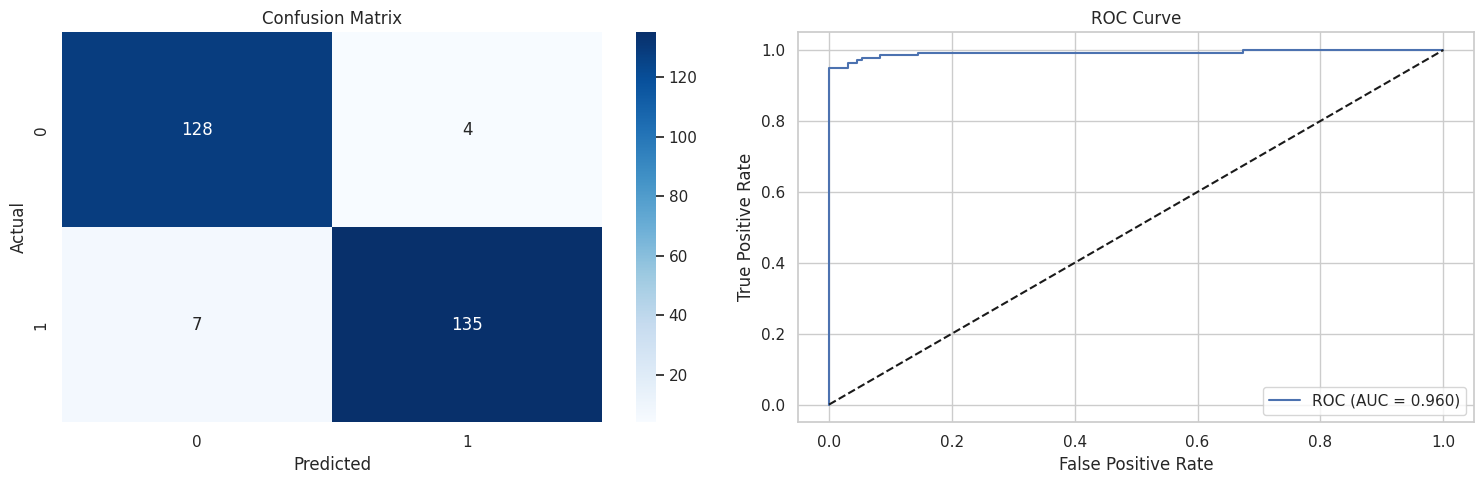


Confusion Matrix Statistics:
True Negatives: 128
False Positives (Type I Error): 4
False Negatives (Type II Error): 7
True Positives: 135
Type I Error Rate (False Positive Rate): 0.0303
Type II Error Rate (False Negative Rate): 0.0493


In [ ]:
# 可视化评估结果
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve

# 获取预测结果
val_predictions = classifier.predict(X_val)

# 创建图形
plt.figure(figsize=(15, 5))

# 1. 混淆矩阵
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_val, val_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 2. ROC曲线
plt.subplot(1, 2, 2)
proba = np.mean([clf.predict_proba(classifier.extract_features(X_val, is_training=False))
                 for clf in classifier.trained_classifiers.values()], axis=0)
fpr, tpr, _ = roc_curve(y_val, proba[:, 1])
plt.plot(fpr, tpr, label=f'ROC (AUC = {metrics["ROC-AUC"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.tight_layout()
plt.show()

# 打印详细的混淆矩阵统计
print("\nConfusion Matrix Statistics:")
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives (Type I Error): {fp}")
print(f"False Negatives (Type II Error): {fn}")
print(f"True Positives: {tp}")
print(f"Type I Error Rate (False Positive Rate): {fp/(fp+tn):.4f}")
print(f"Type II Error Rate (False Negative Rate): {fn/(fn+tp):.4f}")